In [106]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

server = "localhost,5432"
db_name = "ModMon"
driver = "/usr/local/lib/psqlodbcw.so"

cnxn = pyodbc.connect("DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + db_name + ";Trusted_Connection=yes;")
cursor = cnxn.cursor()

In [107]:
models = pd.read_sql('SELECT models.modelID, models.name, models.teamName, models.description, researchQuestions.description AS question FROM models, researchQuestions WHERE models.questionID=researchQuestions.questionID;', cnxn)
models

,modelid,name,teamname,description,question
0,1,synpuf_stats,REG,"Not really a model, descriptive stats",Descriptive stats for Synpuf database
1,2,synpuf-R,Another Team,Bag of words model,synpuf


Visualisation ideas
==

In [108]:
results = pd.read_sql('SELECT * FROM results;', cnxn)
results.head()

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,0.0.1,2,1,2020-01-01,1,jan_births,23.0,None,None
1,1,0.0.1,2,1,2020-01-01,1,aug_births,13.0,None,None
2,1,0.0.1,2,1,2020-01-01,1,born_60,1.0,None,None
3,1,0.0.1,2,1,2020-01-01,1,population_size,200.0,None,None
4,1,0.0.1,2,1,2020-01-01,1,mortality,5.0,None,None


[Text(0, 0.5, 'Runs in ModMon DB'), Text(0.5, 0, 'Model')]

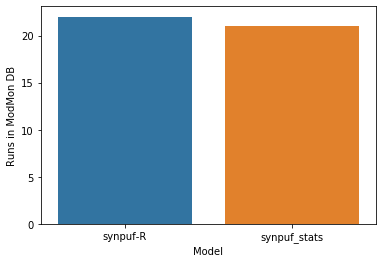

In [109]:
# Number of times each model has been run
query = """
SELECT m.name, COUNT( DISTINCT r.runid )
FROM results AS r, models AS m
WHERE r.modelid = m.modelid
GROUP BY m.name;
"""
data = pd.read_sql(query, cnxn)
bar = sns.barplot(x='name', y='count', data=data)
bar.set(xlabel='Model', ylabel="Runs in ModMon DB")

## View a particular metric for a model across time and for different versions

In [110]:
metric = 'mortality'
model = 1
query = """
SELECT r.metric, r.value, r.modelversion, d.databasename
FROM results AS r, datasets AS d
WHERE modelID={}
AND r.testdatasetid = d.datasetid
AND metric='{}';
""".format(model, metric)
plot3_results = pd.read_sql(query, cnxn)
plot3_results

,metric,value,modelversion,databasename
0,mortality,5.00,0.0.1,WEEK_01
1,mortality,5.00,0.0.1,WEEK_01
2,mortality,4.75,0.0.1,WEEK_03
3,mortality,4.80,0.0.1,WEEK_04
4,mortality,5.00,0.0.1,WEEK_05
5,mortality,5.00,0.0.1,WEEK_06
6,mortality,5.00,0.0.1,WEEK_07
7,mortality,5.00,0.0.1,WEEK_08
8,mortality,5.00,0.0.1,WEEK_09
9,mortality,5.20,0.0.1,WEEK_10


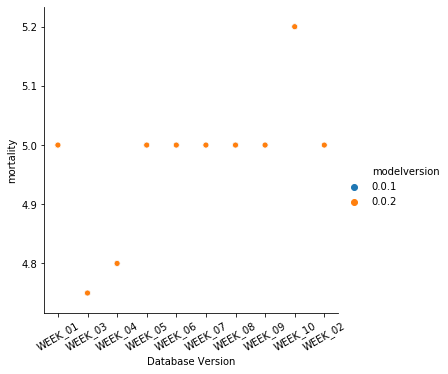

In [111]:
chart = sns.relplot(x='databasename', y='value', hue='modelversion', data=plot3_results)
chart.set_xticklabels(rotation=30)
chart.set(xlabel='Database Version', ylabel=metric)
chart

In [145]:
query = """
SELECT m.name, r.metric, r.value, d.databasename, d.datasetid, m.modelid, r.modelversion, q.description
FROM results AS r, datasets AS d, models AS m, researchQuestions AS q
WHERE r.testdatasetid = d.datasetid
AND r.modelid = m.modelid
AND m.questionid = q.questionid;
"""
results = pd.read_sql(query, cnxn)
results = results.sort_values(by=['modelid', 'datasetid'])
results

,name,metric,value,databasename,datasetid,modelid,modelversion,description
8,synpuf_stats,jan_births,23.0000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
9,synpuf_stats,aug_births,13.0000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
10,synpuf_stats,born_60,1.0000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
11,synpuf_stats,population_size,200.0000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
12,synpuf_stats,mortality,5.0000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
...,...,...,...,...,...,...,...,...
81,synpuf-R,LogLoss,0.7080,WEEK_10,13,2,1.1,synpuf
168,synpuf-R,AUC,0.5078,WEEK_10,13,2,1.0,synpuf
169,synpuf-R,LogLoss,0.7080,WEEK_10,13,2,1.0,synpuf
88,synpuf-R,AUC,0.6690,WEEK_00,17,2,1.0,synpuf


In [147]:
results['model'] = results['name'] + '_' + results['modelversion']
results['titles'] = results['metric'] + ' (' + results['description'] + ')'
results.head()

,name,metric,value,databasename,datasetid,modelid,modelversion,description,model,titles
8,synpuf_stats,jan_births,23.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,jan_births (Descriptive stats for Synpuf datab...
9,synpuf_stats,aug_births,13.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,aug_births (Descriptive stats for Synpuf datab...
10,synpuf_stats,born_60,1.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,born_60 (Descriptive stats for Synpuf database)
11,synpuf_stats,population_size,200.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,population_size (Descriptive stats for Synpuf ...
12,synpuf_stats,mortality,5.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,mortality (Descriptive stats for Synpuf database)


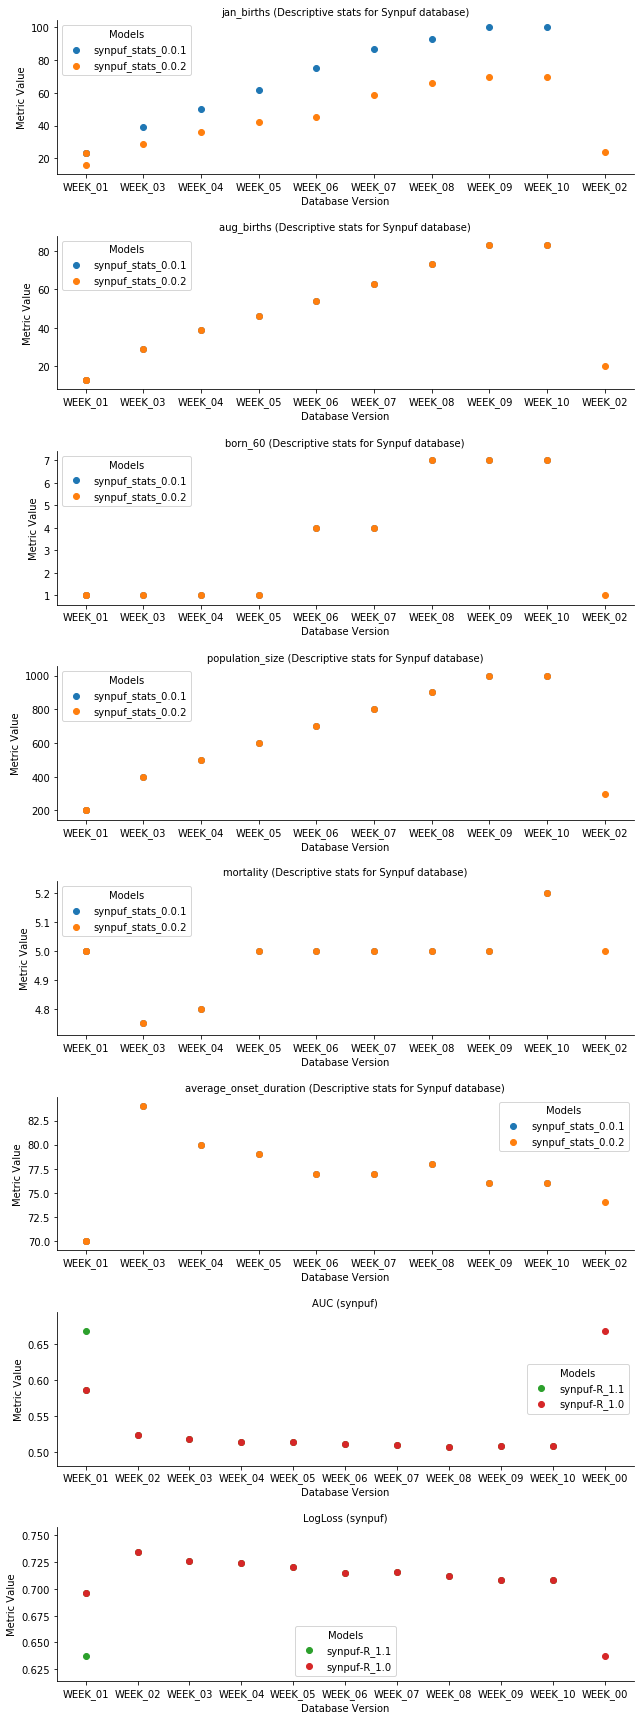

In [148]:
#TODO: Separate by research question
g = sns.FacetGrid(data=results, row='titles', sharey=False, sharex=False, aspect=3, hue='model')
g.map(plt.scatter, "databasename", "value").fig.subplots_adjust(hspace=.4)
# g.set_xticklabels(rotation=45)
g.set(xlabel='Database Version', ylabel='Metric Value')
g.set_titles(col_template = "{col_name}", row_template = '{row_name}')
for i, _ in enumerate(g.axes):
    g.axes[i][0].legend(title = "Models")

# plt.legend(loc='upper left')
# plt.show()